In [18]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import PIL
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from itertools import chain
import os
import cv2

from matplotlib_scalebar.scalebar import ScaleBar
import glob
import numpy
import scipy.cluster.hierarchy as hcluster

# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook
from scipy.signal import find_peaks
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import os

m_p=1
Fps=1



### function to find msd, returns list of msd values and plots the individual particles msds when called

def find_msd(data,max_lag_time):  ## takes in dataframe and a max lag time
    matrix_msd=[] ## to store all particle trajectories (each row a particle trajectory)
    d_t=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        for t in range(1,max_lag_time):  ## loop over lag times
            del_t.append(t)
            dx=[(x_list[j+t]-x_list[j]) for j in range(len(x_list)-int(max_lag_time))]
            dy=[(y_list[j+t]-y_list[j]) for j in range(len(y_list)-int(max_lag_time))]
            disp=[np.sqrt(dx[i]**2+dy[i]**2) for i in range(len(dx))] ## find displacement
            msd_temp=np.mean(disp)## mean 
            msd_part_i.append(msd_temp)
        #plt.loglog(del_t,msd_part_i,alpha=0.1,color='black')
        matrix_msd.append(msd_part_i)
        d_t.append(del_t)
        plt.xlabel('lag_time')
        plt.ylabel('msd')
        
        #plt.show() ###shows individual particle msds while calling the function
    matrix_msd_arr = np.array(matrix_msd)
    # delete all the rows with any NaN value( some rows become nan as there are too less trajectory frames compared to max lag time)
    indexList = [np.any(i) for i in np.isnan(matrix_msd_arr )]
    matrix_msd_corrected  = np.delete(matrix_msd_arr , indexList, axis=0)
    msd = np.average(matrix_msd_corrected, axis=0)  ## average columns of the matrix(ie over all positions for a lag time)
    return msd,del_t
    
def find_traj_data(frames,conect,mem,size,mass,filt):
    ## locate features in all frames( fluroscent bleach after 200 frames)
    f = tp.batch(frames[:400],size, minmass=mass); ### locate features with radius 7 and minimum brightness 100 from frame 100

    ## link different frames
    t = tp.link(f,conect, memory=mem) ### features must uptot 5 pixels in the next frame to be considered a trajectory (memory incase it disapears for some frames)

    #### trajectories that last fewer than 30 frames are disguarded
    t1 = tp.filter_stubs(t,filt)
    # Compare the number of particles in the unfiltered and filtered data.
    #print('Before:', t['particle'].nunique())
    #print('After:', t1['particle'].nunique())

     #tp.plot_traj(t1);

    ## subtract any drift in image(look at image from the center of mass)
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    tm.rename(columns = {'size':'area'}, inplace = True)
    data = pd.DataFrame()

    for item in set(tm.particle):
    
        sub = tm[tm.particle==item]
    
        dx = m_p*np.diff(sub.x)/1. # differnece between to frame for X postion
        dy = m_p*np.diff(sub.y)/1. #wdiffernece between to frame for Y postion
        dt = np.diff(sub.frame)/Fps #to calcul the time
        dr=((np.sqrt(dy**2 + dx**2)))
        tan = (dy/dx) # to calcul the slope
        ang_d=abs((np.arctan(tan)*57.2958))
        #print(np.diff(sub.frame))
        v = (((np.sqrt(dy**2 + dx**2)))/dt) # to calcul the velocity  12 microns per pixel
        for x, y, dx, dy,disp, v,ang_disp,area, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy),dr ,v,ang_d,sub.area[:-1] ,dt,sub.frame[:-1],):
            data = data.append([{'dx': dx,
            'dy': dy,
             'x': x,
             'y': y,
            'frame': frame,
             'particle': item,
              'disp':disp,                  
             'dt' : dt,
             'area':area,
              'ang_disp':ang_disp,                   
             'v' : v,}])
       
    ## correct angles based on a cartesian plane convert to radian
    ang_list=list(data['ang_disp'])
    dx_list=list(data['x'])
    dy_list=list(data['y'])
    #print(dx_list)
    #69.123*0.0174533
    ang_d_corrected=[]  
    for i in range(0,len(ang_list)):
        if dx_list[i]>0 and dy_list[i]>0:
            ang_d_corrected.append((ang_list[i])*0.0174533)
        if dx_list[i]<0 and dy_list[i]>0:
            ang_d_corrected.append((180-ang_list[i])*0.0174533)
        if dx_list[i]<0 and dy_list[i]<0:
            ang_d_corrected.append((180+ang_list[i])*0.0174533)
        if dx_list[i]>0 and dy_list[i]<0:
            ang_d_corrected.append(((360-ang_list[i])*0.0174533))
    data['ang_corr']=ang_d_corrected
    
    utraj = np.unique(tm.particle)
    num_traj = utraj.size
    cdict = {}

   # fig, ax = plt.subplots(figsize=(8,8))
   # ax.cla()
    #for i in range(num_traj):
    #    iid = tm.particle == utraj[i]
    #    xi = np.array(tm.x[iid])
     #   yi = np.array(tm.y[iid])
        # print(xi.shape)
    
      #  if (xi.size > 0):
      #      plt.plot(xi,yi,'-',ms=2,lw=0.5)
       #     p = ax.plot(xi,yi,'-',ms=2,lw=0.5)
         #   color = p[0].get_color()
         #   cdict[utraj[i]] = color 
          #  plt.plot(xi[xi.size-1],yi[xi.size-1],'o',ms=4,c=color,markerfacecolor='w',lw=0.5)
    return tm,data
%matplotlib notebook
def find_ee_distance(data):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    xi=[]
    yi=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dx=(x_list[0]-x_list[-1])
        dy=(y_list[0]-y_list[-1])
        disp=np.sqrt(dx**2+dy**2) ## find displacement
        disp_part_i.append(disp)
        xi.append(x_list[-1])
        yi.append(y_list[-1])
        part_id.append(i)
    return disp_part_i,xi,yi,part_id

def find_rad_distance(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id

def in_out(min_dist,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax):
    iid_in=[]
    iid_out=[]
    %matplotlib notebook
    V_filtered_list=[]
    fig, ax = plt.subplots()
    ax.axis("off")
    for ind,i in enumerate(iidr):
        
        if ee[ind]>min_dist and ri[ind]>rmin and ri[ind]<rmax:
            #plt.scatter(xe[i],ye[i],color='yellow',s=10)
            df=data.loc[data['particle'] ==i]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            x=trajx
            y=trajy
            c_map = plt.cm.get_cmap('cool')

            # Normalize the color values between 0 and 1
            norm = plt.Normalize(0, len(x) - 1)
    
            # Plot the trajectories with a colormap
            for i in range(len(x) - 1):
                color = c_map(norm(i))
                plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color=color)


            # Add a colorbar to show the fade in between
            sm = plt.cm.ScalarMappable(cmap=c_map, norm=norm)
            sm.set_array([])
            #cbar = plt.colorbar(sm)


            #plt.xlabel('X')
            #plt.ylabel('Y')
            #plt.title('Particle Trajectories')
       
            for i in range(0,len(iidr)):
        
                if ri[i]>rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                    iid_in.append(i)
                
          
                if ri[i]<rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                
                    iid_out.append(i)
         
    scalebar = ScaleBar(41.7, "nm", scale_loc='bottom', length_fraction=0.25, color='white', box_alpha=0)


    ax.add_artist(scalebar)


    plt.plot()
    sm = plt.cm.ScalarMappable(cmap=c_map, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.imshow(frames[0]);
    if (len(iid_out)+len(iid_in))!=0:
        ratio_in_out=len(iid_in)/(len(iid_out)+len(iid_in))
    else:
        ratio_in_out=0
    return ratio_in_out,V_filtered_list

def find_cm(frames,tm,size):
    ##finding center of cell, is taking center of mass ok? how to define the center from image?
    f = tp.batch(frames[:200],size, minmass=100); ### locate features with radius 7 and minimum brightness 100 from frame 100
    x_vals=f['x'].tolist()
    y_vals=f['y'].tolist()
    mass=f['raw_mass'].tolist()
    x_cm=0
    y_cm=0
    for i in range(0,len(mass)):## takin
        x_cm+=(x_vals[i]*mass[i])/np.sum(mass)
        y_cm+=(y_vals[i]*mass[i])/np.sum(mass)
    
     
    return x_cm,y_cm
def pot_traj(data,frame):
    df=data.loc[data['frame'] ==frame]
    x_list=df['x'].tolist()
    y_list=df['y'].tolist()
    return x_list,y_list
    


In [2]:
from tqdm import tqdm
vel_avg=[]
files=np.arange(1,56).tolist()
files.remove(22)
files.remove(30)
files.remove(43)
#files.remove(3)
for i in range(0,53):
    if i in range(11,21):
        files.remove(i)
    if i in range(48,52):
        files.remove(i)
    if i in range(33,42):
        files.remove(i)
        
print(files)   
treatment=[]
angle_store=[]
time_store=[]
in_out_av=[]
vel_avg=[]
ratios=[]
for i in tqdm(files):
    print(i)
    #print(i)
    boundary=10
    if i>=1 and i<= 7:
        treatment.append('J wt')
        
    elif i>=8 and i<=10:
        treatment.append('J ck666')
    elif i>=11 and i<=12:
        treatment.append('J bleb')
    elif i>=13 and i<=16:
        treatment.append('J smihf2')
    elif i>=17 and i<=20:
        treatment.append('J ck666+smihf2')
    elif i>=21 and i<=28:
        treatment.append('M wt')
    elif i>=29 and i<=32:
        treatment.append('M ck666')
   # elif (i>=33 and i<=34) or (i>=48 and i<=51) :
    elif (i>=48 and i<=51) :
        treatment.append('M bleb')
    elif i>=35 and i<=37:
        treatment.append('M ck666+smihf2')
    elif i>=38 and i<=41:
        treatment.append('M smihf2')
    elif i>=42 and i<=47:
        treatment.append('M waspneg')
    elif i>=52 and i<=53:
        treatment.append('J ck666')
    elif i>=54 and i<=55:
        treatment.append('M ck666')
   
   
    

    image_sequence_path = '%d/*.jpg'%i
    
    
    @pims.pipeline
    def gray(image):
        return image[:,:, 1]  # Take just the green channel
    frames= (pims.open( image_sequence_path))

    conect=4
    mem=3
    size=7
    mass=100
    filt=30
   
    tm,data=find_traj_data(frames,conect,mem,size,mass,filt)

    ee,xe,ye,iid=find_ee_distance(tm)
    x_cm,y_cm=find_cm(frames,tm,size)


    ri,rf,iidr=find_rad_distance(tm,x_cm,y_cm)
    ratio=in_out(4,ri,rf,xe,ye,ee,iidr,data,frames)  
    data
    print(ratio)
    ratios.append(ratio)
    in_out_av.append(ratio)
    Vel=data['v'].tolist()
   
    vel_avg.append(np.mean(Vel))
    


        
   
    
            

Frame 199: 36 features


100%|███████████████████████████████████████████| 29/29 [13:20<00:00, 27.61s/it]

0.5714285714285714


Frame 199: 43 features


<IPython.core.display.Javascript object>


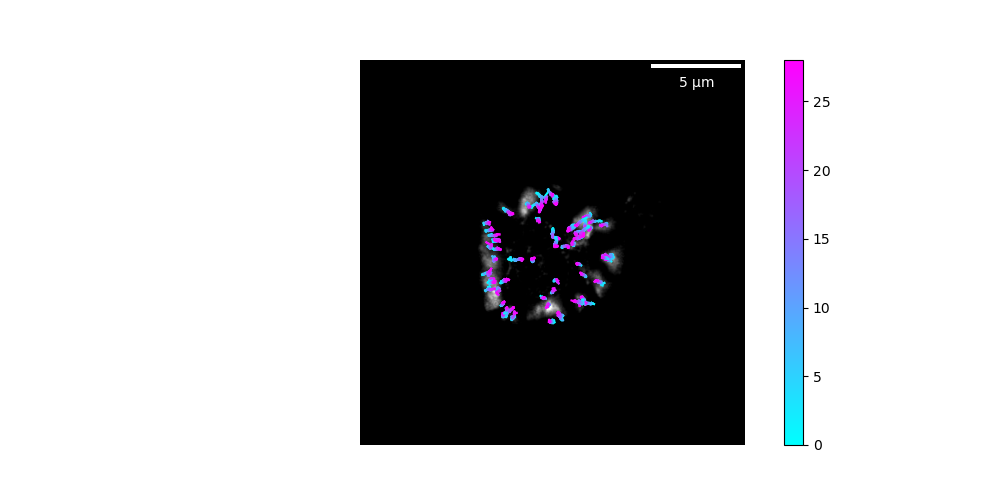

100%|███████████████████████████████████████████| 29/29 [08:19<00:00, 17.24s/it]


In [24]:
def BrightnessContrast(filename,brightness, contrast,image_no,show):
    img = cv2.imread(filename)
    effect = controller(img, brightness, contrast)
    
    if show==1:
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
        axs[0].set_title('Original Image')     
        axs[0].axis('off')
    
        axs[1].imshow(cv2.cvtColor(effect, cv2.COLOR_BGR2RGB))     
        axs[1].set_title('Modified Image')     
        axs[1].axis('off')

    gray = cv2.cvtColor(effect, cv2.COLOR_BGR2GRAY)
    #plt.imshow('Effect', effect)
    if not os.path.exists('image_clear'):
        os.makedirs('image_clear')

    # Save the effect image in the 'image_clear' folder with a sequential number
    output_path = os.path.join('image_clear', f'processed_image_{image_no}.jpg')
    cv2.imwrite(output_path,  gray)

    # Increment the image number for the next iteration
    #image_number += 1

    #plt.show()
    return effect
def controller(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            max = 255
        else:
            shadow = 0
            max = 255 + brightness

        al_pha = (max - shadow) / 255
        ga_mma = shadow
        cal = cv2.addWeighted(img, al_pha, img, 0, ga_mma)
    else:
        cal = img

    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)
        cal = cv2.addWeighted(cal, Alpha, cal, 0, Gamma)

    #cv2.putText(cal, 'B:{},C:{}'.format(brightness, contrast), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    return cal

files=np.arange(1,2).tolist()
files=np.arange(1,56).tolist()
files.remove(22)
files.remove(30)
files.remove(43)
#files.remove(3)
for i in range(0,53):
    if i in range(11,21):
        files.remove(i)
    if i in range(48,52):
        files.remove(i)
    if i in range(33,42):
        files.remove(i)
        
print(files)   
treatment=[]
angle_store=[]
time_store=[]
in_out_av=[]
vel_avg=[]
ratios=[]
for i in tqdm(files):
    print(i)
    #print(i)
    boundary=10
    if i>=1 and i<= 7:
        treatment.append('J wt')
        
    elif i>=8 and i<=10:
        treatment.append('J ck666')
    elif i>=11 and i<=12:
        treatment.append('J bleb')
    elif i>=13 and i<=16:
        treatment.append('J smihf2')
    elif i>=17 and i<=20:
        treatment.append('J ck666+smihf2')
    elif i>=21 and i<=28:
        treatment.append('M wt')
    elif i>=29 and i<=32:
        treatment.append('M ck666')
   # elif (i>=33 and i<=34) or (i>=48 and i<=51) :
    elif (i>=48 and i<=51) :
        treatment.append('M bleb')
    elif i>=35 and i<=37:
        treatment.append('M ck666+smihf2')
    elif i>=38 and i<=41:
        treatment.append('M smihf2')
    elif i>=42 and i<=47:
        treatment.append('M waspneg')
    elif i>=52 and i<=53:
        treatment.append('J ck666')
    elif i>=54 and i<=55:
        treatment.append('M ck666')
    file_list = os.listdir(folder_path)
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sorted_image_files = sorted(image_files)
    # Loop through the image files and print their names
    for count,image_file in enumerate(sorted_image_files):
    
        
        image_path = os.path.join(folder_path, image_file)
        if count==1:
            rmin=5
        print(image_path)
        c=150
    
        # Set the brightness and contrast values here, keeb brighness constant
        brightness_value = 255  # Adjust as needed (-255 to 255)
        contrast_value = c    # Adjust as needed (-127 to 127)
         
        final_img=BrightnessContrast(image_path,brightness_value, contrast_value,count,0)
        if count==200:
            break
            
    # Load your frames and set other parameters
    ee_cut=3.5
    ratio_list=[]
    
    ee_cut=3.5
    ratio_list=[]
    frames = pims.open('image_clear/*.jpg')

    fig, ax = plt.subplots()
    ax.axis("off")
    n = 1
    f = tp.locate(frames[n], size, minmass=mass)
    #plt.imshow(frames[n])
    tp.annotate(f, frames[n],plot_style={'markersize':10})
    # Create a white scale bar with a smaller width
    rmax=100

    tm,data=find_traj_data(frames,conect,mem,size,mass,filt)

    ee,xe,ye,iid=find_ee_distance(data)
    x_cm,y_cm=find_cm(frames,tm,size)
    plt.scatter(x_cm,y_cm,s=10,color='r')
   
    ri,rf,iidr=find_rad_distance(data,x_cm,y_cm)
    ratio,V=in_out(ee_cut,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax)   
    ratio_list.append(ratio)

    ratios.append(ratio_list[0])

In [ ]:
 image_sequence_path = '%d/*.jpg'%i
    
    
    @pims.pipeline
    def gray(image):
        return image[:,:, 1]  # Take just the green channel
    frames= (pims.open( image_sequence_path))

    conect=4
    mem=3
    size=7
    mass=100
    filt=30
   
    tm,data=find_traj_data(frames,conect,mem,size,mass,filt)

    ee,xe,ye,iid=find_ee_distance(tm)
    x_cm,y_cm=find_cm(frames,tm,size)


    ri,rf,iidr=find_rad_distance(tm,x_cm,y_cm)
    ratio=in_out(4,ri,rf,xe,ye,ee,iidr,data,frames)  
    data
    print(ratio)
    ratios.append(ratio)
    in_out_av.append(ratio)
    Vel=data['v'].tolist()
   
    vel_avg.append(np.mean(Vel))
    

In [11]:
print(ratios[10])
print(treatment[10])

0.7682926829268293
M wt


<IPython.core.display.Javascript object>


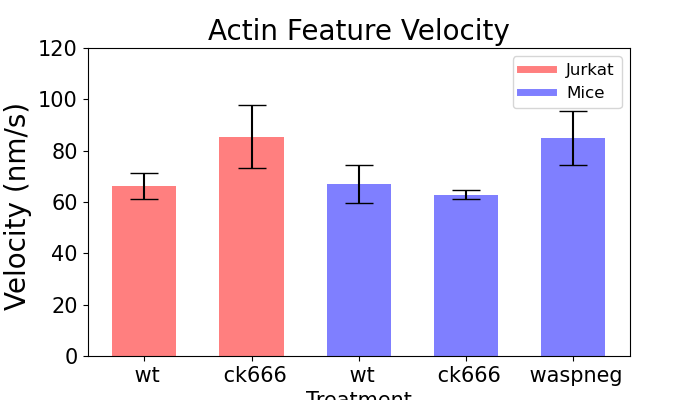

[0 1 2 3 4]
dict_values([66.34841515260723, 85.48985083972897, 67.008858590306, 62.884990140051436, 84.96991054786214])
dict_values([5.073243814980691, 12.145578552831994, 7.299087490613759, 1.7018799537329645, 10.5595796882282])
P-Value for J ck666 vs. J wt: 0.010101010101010102
P-Value for J ck666 vs. M ck666: 0.0119252335930176
P-Value for J ck666 vs. M waspneg: 1.0
P-Value for J ck666 vs. M wt: 0.030303030303030304
P-Value for J wt vs. M ck666: 0.05091315780184361
P-Value for J wt vs. M waspneg: 0.005050505050505051
P-Value for J wt vs. M wt: 1.0
P-Value for M ck666 vs. M waspneg: 0.0119252335930176
P-Value for M ck666 vs. M wt: 0.5152162726967707
P-Value for M waspneg vs. M wt: 0.010101010101010102


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
vel_new=[]
vel_avg2=[i*2*41.7 for i in vel_avg]
# Create a dictionary to store the sums and counts for each string
values = vel_avg2

strings =treatment
# Create a list of unique treatment groups
treatment_groups = np.unique([label.split("_")[0] for label in strings])

# Initialize dictionaries to store p-values for each pair of groups
p_values = {}

# Calculate p-value for each pair of groups using Student's t-test
for i in range(len(treatment_groups)):
    for j in range(i + 1, len(treatment_groups)):
        group1 = treatment_groups[i]
        group2 = treatment_groups[j]
        
        # Extract values for the two groups
        group1_values = [value for value, label in zip(values, strings) if label.startswith(group1)]
        group2_values = [value for value, label in zip(values, strings) if label.startswith(group2)]
        
        # Calculate the t-statistic and p-value using Student's t-test
        _, p_value = mannwhitneyu(group1_values, group2_values,alternative='two-sided')
        
        # Store the p-value for this pair of groups
        p_values[(group1, group2)] = p_value
# Create a dictionary to store the sums and counts for each string
sums = {}
counts = {}

# Loop over the values and strings lists, updating the sums and counts in the dictionary
for value, string in zip(values, strings):
    if string not in sums:
        sums[string] = 0
        counts[string] = 0
    sums[string] += value
    counts[string] += 1

# Calculate the averages and standard errors for each string
averages = {}
errors = {}
for string in sums:
    averages[string] = sums[string] / counts[string]
    errors[string] = np.sqrt(np.var([value for value, string2 in zip(values, strings) if string2 == string])) / 1  # Standard error

# Plot the bar chart with error bars
x = np.arange(len(averages))
fig, ax = plt.subplots(figsize=(7,4))

colors = []
short_labels = []
for string in averages.keys():
    if string.startswith('J'):
        colors.append('red')
        short_labels.append(string.replace('J', ''))
    elif string.startswith('M'):
        colors.append('blue')
        short_labels.append(string.replace('M', ''))
    else:
        colors.append('gray')
        short_labels.append(string)

ax.bar(x, averages.values(), yerr=errors.values(), align='center', width=0.6,alpha=0.5, ecolor='black', capsize=10, color=colors)

ax.set_xticks(x)
ax.set_xticklabels(short_labels)
ax.set_ylabel('Velocity (nm/s) ',fontsize=20, fontname='Arial')
ax.set_xlabel('Treatment',fontsize=15, fontname='Arial')
ax.set_title('Actin Feature Velocity',fontsize=20, fontname='Arial')
ax.set_ylim(0,120)
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial')
#ax.set_title('TCR direction')
# Create legends
# Create legend handles
red_patch = plt.Line2D([0], [0], color='#ff0000', lw=5, label='Jurkat', alpha=0.5)
blue_patch = plt.Line2D([0], [0], color='blue', lw=5, label='Mice', alpha=0.5)

# Create the plot
ax = plt.gca()

# Set legend font properties
legend_font = FontProperties(family='Arial', size=12)
ax.legend(handles=[red_patch, blue_patch], fontsize=12, title_fontsize=12, prop=legend_font)

plt.show()

print(x)
print(averages.values())
print(errors.values())
for group1, group2 in p_values:
    p_value = p_values[(group1, group2)]
    print(f"P-Value for {group1} vs. {group2}: {p_value}")



Mann-Whitney U Statistic: 102.0
Two-Sided P-Value: 1.0


<IPython.core.display.Javascript object>


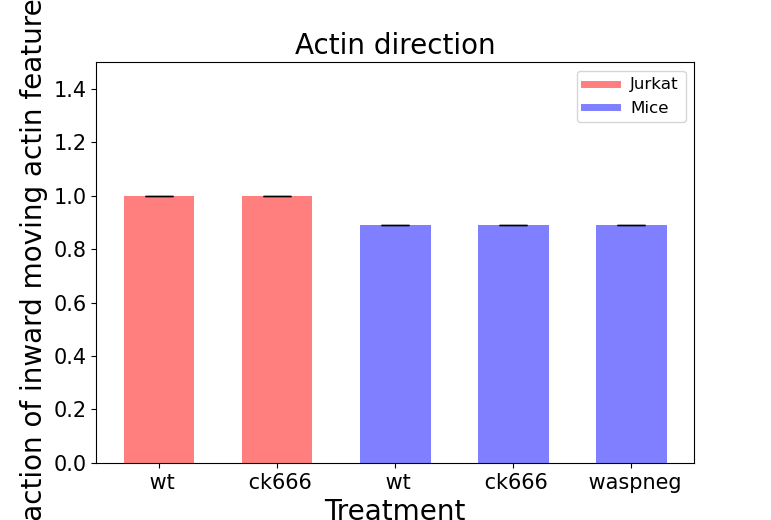

[0 1 2 3 4]
[1.0, 1.0, 0.890625, 0.890625, 0.890625]
[0.0, 0.0, 0.0, 0.0, 0.0]
P-Value for J ck666 vs. J wt: 1.0
P-Value for J ck666 vs. M ck666: 1.0
P-Value for J ck666 vs. M waspneg: 1.0
P-Value for J ck666 vs. M wt: 1.0
P-Value for J wt vs. M ck666: 1.0
P-Value for J wt vs. M waspneg: 1.0
P-Value for J wt vs. M wt: 1.0
P-Value for M ck666 vs. M waspneg: 1.0
P-Value for M ck666 vs. M wt: 1.0
P-Value for M waspneg vs. M wt: 1.0


In [25]:
###   Normalised ###
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

# Create a dictionary to store the sums and counts for each string
values = ratios
strings = treatment

# Separate data into two groups (e.g., 'Jurkat' and 'Mouse')
jurkat_values = [value for value, string in zip(values, strings) if string.startswith('J')]
mouse_values = [value for value, string in zip(values, strings) if string.startswith('M')]

# Calculate the Mann-Whitney U statistic and p-value
u_statistic, p_value = mannwhitneyu(jurkat_values, mouse_values, alternative='two-sided')

# Print the results
print("Mann-Whitney U Statistic:", u_statistic)
print("Two-Sided P-Value:", p_value)
# Create a list of unique treatment groups
treatment_groups = np.unique([label.split("_")[0] for label in strings])

# Initialize dictionaries to store p-values for each pair of groups
p_values = {}

# Calculate p-value for each pair of groups using Student's t-test
for i in range(len(treatment_groups)):
    for j in range(i + 1, len(treatment_groups)):
        group1 = treatment_groups[i]
        group2 = treatment_groups[j]
        
        # Extract values for the two groups
        group1_values = [value for value, label in zip(values, strings) if label.startswith(group1)]
        group2_values = [value for value, label in zip(values, strings) if label.startswith(group2)]
        
        # Calculate the t-statistic and p-value using Student's t-test
        _, p_value = mannwhitneyu(group1_values, group2_values,alternative='two-sided')
        
        # Store the p-value for this pair of groups
        p_values[(group1, group2)] = p_value
# Create a dictionary to store the sums and counts for each string
sums = {}
counts = {}

# Loop over the values and strings lists, updating the sums and counts in the dictionary
for value, string in zip(values, strings):
    if string not in sums:
        sums[string] = 0
        counts[string] = 0
    sums[string] += value
    counts[string] += 1

# Calculate the averages and standard errors for each string
averages = {}
errors = {}
for string in sums:
    averages[string] = sums[string] / counts[string]
    if string.startswith('J'):
        jurkat_wt_value = averages[string]
    errors[string] = np.sqrt(np.var([value / jurkat_wt_value for value, string2 in zip(values, strings) if string2 == string])) / 1  # Standard error

# Plot the bar chart with error bars
x = np.arange(len(averages))
fig, ax = plt.subplots(figsize=(7,4))

colors = []
short_labels = []
for string in averages.keys():
    if string.startswith('J'):
        colors.append('#ff0000')
        short_labels.append(string.replace('J', ''))
    elif string.startswith('M'):
        colors.append('blue')
        short_labels.append(string.replace('M', ''))
    else:
        colors.append('gray')
        short_labels.append(string)

# Normalize values by the Jurkat WT value
normalized_values = [averages[string] / jurkat_wt_value if string.startswith('J') else averages[string] for string in averages]
normalized_errors = [errors[string] / jurkat_wt_value if string.startswith('J') else errors[string] for string in errors]

bars = ax.bar(x, normalized_values, yerr=normalized_errors, align='center',width=0.6, alpha=0.5, ecolor='black', capsize=10, color=colors)

ax.set_xticks(x)
ax.set_xticklabels(short_labels)
ax.set_ylabel('fraction of inward moving actin features', fontsize=20, fontname='Arial')
ax.set_xlabel('Treatment', fontsize=20, fontname='Arial')
ax.set_title('Actin direction', fontsize=20, fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial')
ax.set_ylim(0,1.5)
# Create legend handles
red_patch = plt.Line2D([0], [0], color='#ff0000', lw=5, label='Jurkat', alpha=0.5)
blue_patch = plt.Line2D([0], [0], color='blue', lw=5, label='Mice', alpha=0.5)

# Create the plot
ax = plt.gca()

# Set legend font properties
legend_font = FontProperties(family='Arial', size=12)
ax.legend(handles=[red_patch, blue_patch], fontsize=20, title_fontsize=12, prop=legend_font)

plt.show()
print(x)
print(normalized_values)
print(normalized_errors)

for group1, group2 in p_values:
    p_value = p_values[(group1, group2)]
    print(f"P-Value for {group1} vs. {group2}: {p_value}")



<IPython.core.display.Javascript object>


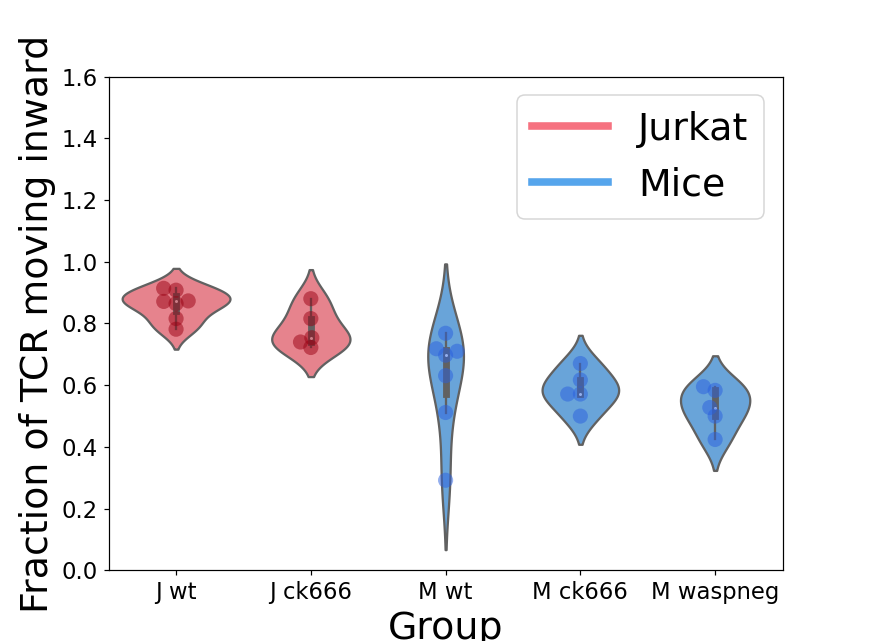

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.font_manager import FontProperties

# Sample data: Replace these with your actual data
values = ratios
strings = treatment  # Assuming labels is your list of labels

# Create a DataFrame from your data
data = pd.DataFrame({'strings': strings, 'values': values})

# Create a custom palette dictionary
custom_palette = {}
custom_palette_scatter = {}
for l in strings:
    if l.startswith('J'):
        custom_palette[l] = '#F67280'
        custom_palette_scatter[l] = '#990012'
    elif l.startswith('M'):
        custom_palette[l] = '#56A5EC'
        custom_palette_scatter[l] = '#2B60DE'
    else:
        custom_palette[l] = 'gray'  # Assign a default color for other labels

# Set the font properties for labels and titles
font_properties = FontProperties(family='Arial', size=25)

# Create a violin plot using Seaborn with the custom palette
plt.figure(figsize=(10, 6))
sns.violinplot(x='strings', y='values', data=data, palette=custom_palette)

# Overlay a swarmplot to show individual data points
sns.swarmplot(x='strings', y='values', data=data, palette=custom_palette_scatter, alpha=0.5, size=10)


# Create legend handles
red_patch = plt.Line2D([0], [0], color='#F67280', lw=5, label='Jurkat')
blue_patch = plt.Line2D([0], [0], color='#56A5EC', lw=5, label='Mice')

# Create the plot
ax = plt.gca()

# Set legend font properties
ax.legend(handles=[red_patch, blue_patch], fontsize=15, title_fontsize=15, prop=font_properties)

# Set title and axis labels with updated font properties
#plt.title('Violin and Swarm Plot by Group', fontproperties=font_properties)
plt.xlabel('Group', fontproperties=font_properties)
plt.ylabel('Fraction of TCR moving inward', fontproperties=font_properties)
plt.ylim(0,1.6)
ax.tick_params(axis='both', labelsize=15)
# Show the plot
plt.show()




<IPython.core.display.Javascript object>


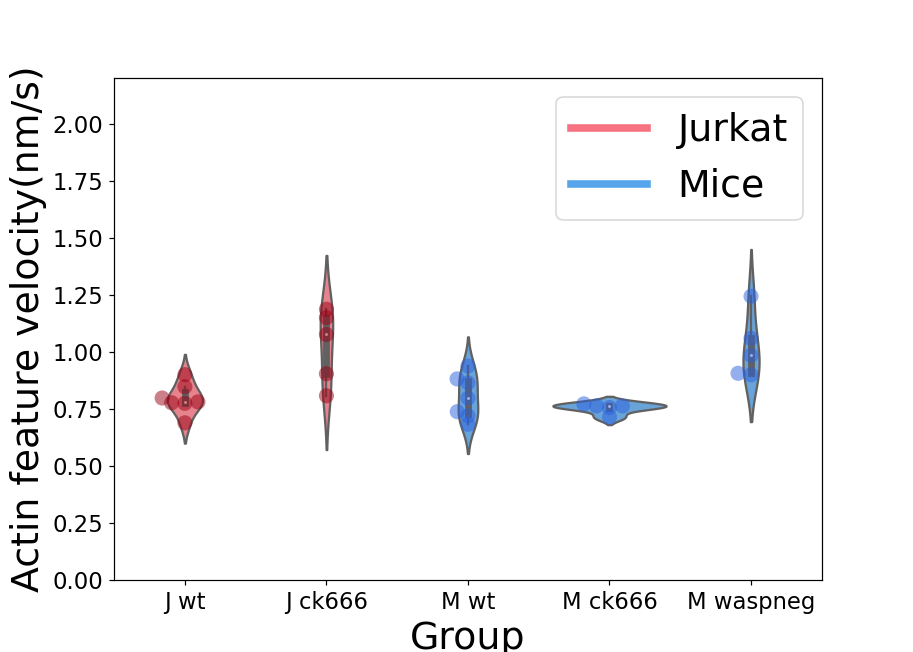

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.font_manager import FontProperties
# Sample data: Replace these with your actual data
vel_avg2=[i for i in vel_avg]
# Create a dictionary to store the sums and counts for each string

# Sample data: Replace these with your actual data
values = vel_avg2
strings = treatment


# Create a DataFrame from your data
data = pd.DataFrame({'strings': strings, 'values': values})

# Create a custom palette dictionary
custom_palette = {}
custom_palette_scatter = {}
for l in strings:
    if l.startswith('J'):
        custom_palette[l] = '#F67280'
        custom_palette_scatter[l] = '#990012'
    elif l.startswith('M'):
        custom_palette[l] = '#56A5EC'
        custom_palette_scatter[l] = '#2B60DE'
    else:
        custom_palette[l] = 'gray'  # Assign a default color for other labels

# Set the font properties for labels and titles
font_properties = FontProperties(family='Arial', size=25)

# Create a violin plot using Seaborn with the custom palette
plt.figure(figsize=(10, 6))
sns.violinplot(x='strings', y='values', data=data, palette=custom_palette)

# Overlay a swarmplot to show individual data points
sns.swarmplot(x='strings', y='values', data=data, palette=custom_palette_scatter, alpha=0.5, size=10)


# Create legend handles
red_patch = plt.Line2D([0], [0], color='#F67280', lw=5, label='Jurkat')
blue_patch = plt.Line2D([0], [0], color='#56A5EC', lw=5, label='Mice')

# Create the plot
ax = plt.gca()

# Set legend font properties
ax.legend(handles=[red_patch, blue_patch], fontsize=10, title_fontsize=10, prop=font_properties)

# Set title and axis labels with updated font properties
#plt.title('Violin and Swarm Plot by Group', fontproperties=font_properties)
plt.xlabel('Group', fontproperties=font_properties)
plt.ylabel('Actin feature velocity(nm/s)', fontproperties=font_properties)
plt.ylim(0,2.2)
ax.tick_params(axis='both', labelsize=15)
# Show the plot
plt.show()



